# Chronos forecasting

The paper behind this approach is here: https://arxiv.org/pdf/2403.07815

The paper introduces Chronos, a framework that adapts language model architectures for time series forecasting. The key aspects are:

1. Approach:
- Converts time series data into tokens through scaling and quantization
- Uses existing transformer language model architectures with minimal modifications
- Trains models on both real and synthetic time series data

2. Key Components:
- TSMixup: Data augmentation technique that combines patterns from different time series
- KernelSynth: Synthetic data generation using Gaussian processes
- Based on T5 transformer architecture, with models ranging from 20M to 710M parameters

3. Main Results:
- Significantly outperforms traditional statistical models and task-specific deep learning models on in-domain datasets
- Achieves competitive zero-shot performance on unseen datasets compared to models specifically trained on those datasets
- Fine-tuning further improves performance on new datasets

4. Key Benefits:
- Eliminates need for task-specific training
- Simplifies forecasting pipelines
- Shows language model architectures can handle time series without specialized modifications
- Provides strong zero-shot forecasting capabilities

5. Limitations:
- Inference speed slower than some specialized models
- Edge cases with very sparse or high-variance time series
- Limited by available high-quality public time series data

The paper demonstrates that language model architectures can be effectively adapted for time series forecasting with minimal modifications, potentially simplifying real-world forecasting applications.

1. See Chronos: https://github.com/amazon-science/chronos-forecasting
2. Docs: https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-chronos.html

In [1]:
!pip install chronos-forecasting

## Forecasting Passenger Traffic

In [2]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt  # requires: pip install matplotlib
import numpy as np

pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cuda",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Forecasting Passenger Traffic

In [3]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"
)

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# quantiles is an fp32 tensor with shape [batch_size, prediction_length, num_quantile_levels]
# mean is an fp32 tensor with shape [batch_size, prediction_length]
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(df["#Passengers"]),
    prediction_length=12,
    quantile_levels=[0.1, 0.5, 0.9],
)

In [4]:
df.head()

Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

In [5]:
df.tail()

Month  #Passengers
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

In [6]:
from chronos import ChronosPipeline, ChronosBoltPipeline

print(ChronosPipeline.predict.__doc__)  # for Chronos models
print(ChronosBoltPipeline.predict.__doc__)  # for Chronos-Bolt models


        Get forecasts for the given time series.

        Refer to the base method (``BaseChronosPipeline.predict``)
        for details on shared parameters.

        Additional parameters
        ---------------------
        num_samples
            Number of sample paths to predict. Defaults to what
            specified in ``self.model.config``.
        temperature
            Temperature to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_k
            Top-k parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_p
            Top-p parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        limit_prediction_length
            Force prediction length smaller or equal than the
            built-in prediction length from the model. False by
            default. When true, fail loudly if longer p

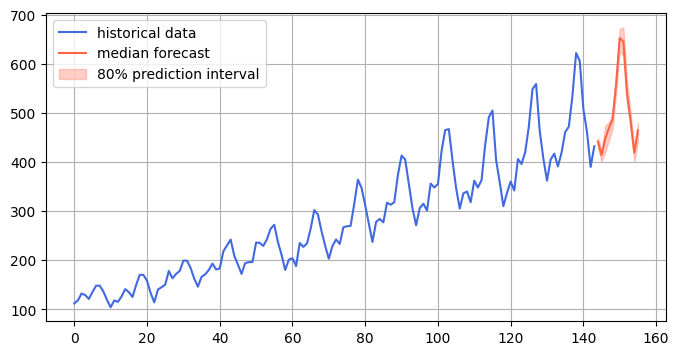

In [7]:
forecast_index = range(len(df), len(df) + 12)
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()


## Forecasting Stocks

In [8]:
# Code to use yfinance to download bitcoin data from FRED ticker CBBTCUSD

!pip install yfinance

import yfinance as yf

In [9]:
# Download Stock data
df = yf.download("C", start="2020-01-01", end="2025-03-20")

# Print the downloaded data
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open    Volume
Ticker              C          C          C          C         C
Date                                                            
2020-01-02  66.661324  66.685942  65.676541  65.758605  12728900
2020-01-03  65.405746  66.078679  65.200584  65.487816  12437400
2020-01-06  65.200569  65.282639  64.601499  64.601499  10059500
2020-01-07  64.634323  65.077474  64.609705  65.069266  10469100
2020-01-08  65.126709  65.651924  64.568667  64.642523  11292400

In [10]:
f_len = 32
col_name = 'Close'

quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(df[col_name].dropna().values), # Convert the Pandas Series to a NumPy array and drop NaN values before creating the tensor
    prediction_length=f_len,
    quantile_levels=[0.1, 0.5, 0.9],
)

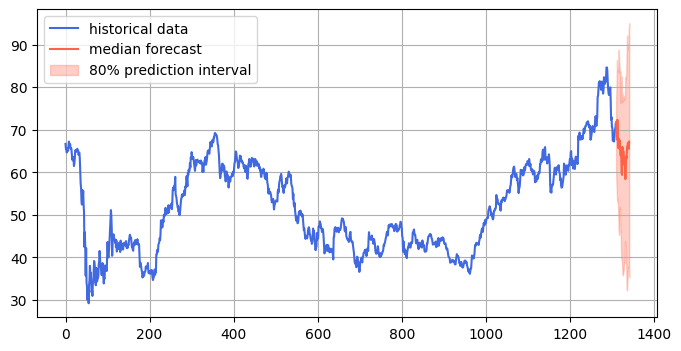

In [11]:
forecast_index = range(len(df), len(df) + f_len)
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

plt.figure(figsize=(8, 4))
plt.plot(np.array(df[col_name]), color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

## Treasuries (10 yr)

In [12]:
df = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=DFII10&scale=left&cosd=2020-03-20&coed=2025-03-20&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2025-03-21&revision_date=2025-03-21&nd=2003-01-02')
df.head()

observation_date  DFII10
0       2020-03-20    0.17
1       2020-03-23   -0.04
2       2020-03-24   -0.13
3       2020-03-25   -0.19
4       2020-03-26   -0.24

In [13]:
f_len = 64
col_name = 'DFII10'

quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(df[col_name].dropna().values), # Convert the Pandas Series to a NumPy array and drop NaN values before creating the tensor
    prediction_length=f_len,
    quantile_levels=[0.1, 0.5, 0.9],
)

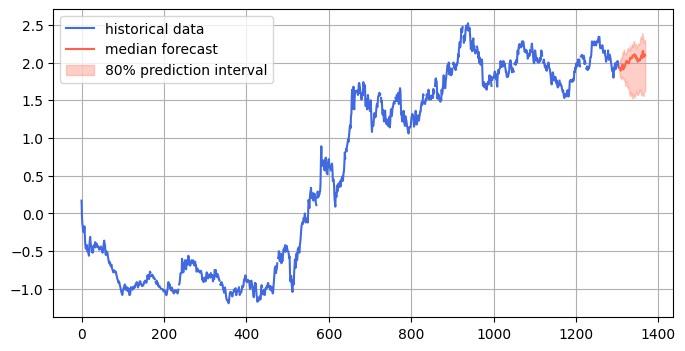

In [14]:
forecast_index = range(len(df), len(df) + f_len)
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

plt.figure(figsize=(8, 4))
plt.plot(np.array(df[col_name]), color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

## Cryptocurrencies

In [15]:
df = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=CBBTCUSD&scale=left&cosd=2020-03-20&coed=2025-03-20&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily%2C%207-Day&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2025-03-21&revision_date=2025-03-21&nd=2014-12-01')
df.head()

observation_date  CBBTCUSD
0       2020-03-20   6215.40
1       2020-03-21   6168.72
2       2020-03-22   5791.69
3       2020-03-23   6583.38
4       2020-03-24   6742.21

In [16]:
f_len = 64
col_name = 'CBBTCUSD'

quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(df[col_name].dropna().values), # Convert the Pandas Series to a NumPy array and drop NaN values before creating the tensor
    prediction_length=f_len,
    quantile_levels=[0.1, 0.5, 0.9],
)

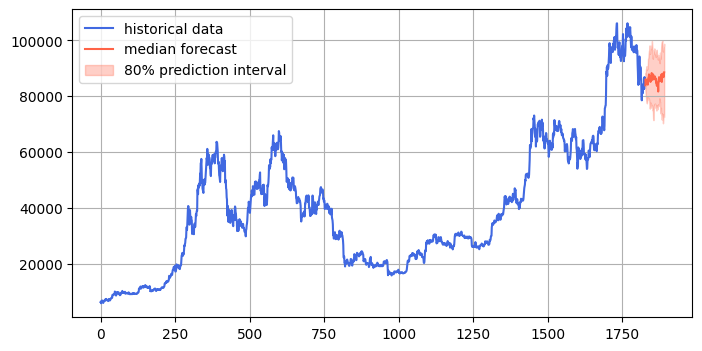

In [17]:
forecast_index = range(len(df), len(df) + f_len)
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

plt.figure(figsize=(8, 4))
plt.plot(np.array(df[col_name]), color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()